In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import annotations
import os
from typing import Any, TypeVar, Iterable, Literal
import PIL.Image
from pathlib import Path
from ds_contrib.core.paths import list_paths
import numpy as np

In [17]:
DATA_ROOT = Path("../data/encenitas_pipeline")
CONVNEXT_SEGMENTATION = DATA_ROOT / "uuid3200/segmentation"
POOLFORMER_SEGMENTATION = DATA_ROOT / "uuid3210/segmentation"
IMAGES_ROOT = DATA_ROOT / "images"

In [18]:
paths = list_paths(CONVNEXT_SEGMENTATION, recursive=True)

In [19]:
from typing import Callable


def map_files_path_based(
    base_file, mappings: dict[str, Callable], base_file_key: str
) -> dict[str, Path]:
    # map file paths based on corresponding base file path and mapping function
    # base_file: PathLike
    # mappings: Iterable[Callable[[Path], Path]]
    # returns: Iterable[Path]
    base_file = Path(base_file)
    result_dict = {base_file_key: base_file}
    for k, mapping_func in mappings.items():
        result_dict[k] = mapping_func(base_file)

    return result_dict

In [20]:
poolformer_mapping = lambda p: POOLFORMER_SEGMENTATION / p.name
convnext_mapping = lambda p: CONVNEXT_SEGMENTATION / p.name

In [24]:
from functools import partial

samples = list(
    map(
        partial(
            map_files_path_based,
            mappings={"poolformer": poolformer_mapping, "convnext": convnext_mapping},
            base_file_key="image",
        ),
        sorted(list_paths(IMAGES_ROOT), key=lambda p: int(p.stem)),
    )
)

In [34]:
def open_sample(samples, id):
    sample = {k: PIL.Image.open(v) for k, v in samples[id].items()}
    return sample

In [65]:
from ds_contrib.core.plotting import Color, ImageLike, plot
from ds_contrib.core.plotting import bin_mask_overlay

colors = [
    Color.RED,
    Color.BLUE,
    Color.CYAN,
    Color.PINK,
    Color.YELLOW,
    Color.GREEN,
    Color.ORANGE,
    Color.PURPLE,
    Color.BROWN,
]


def overlay_all_masks(image, masks, transparency=0.5):
    canvas = image.copy()
    for mask, color in zip(masks, colors):
        canvas = bin_mask_overlay(
            canvas, mask, mask_color=color, transparency=transparency
        )
    return canvas


def overlay_sample(sample: dict[str, ImageLike], transparency=0.5):
    image = sample["image"]
    masks = [np.array(v) for k, v in sample.items() if k != "image"]
    return overlay_all_masks(image, masks, transparency=transparency)

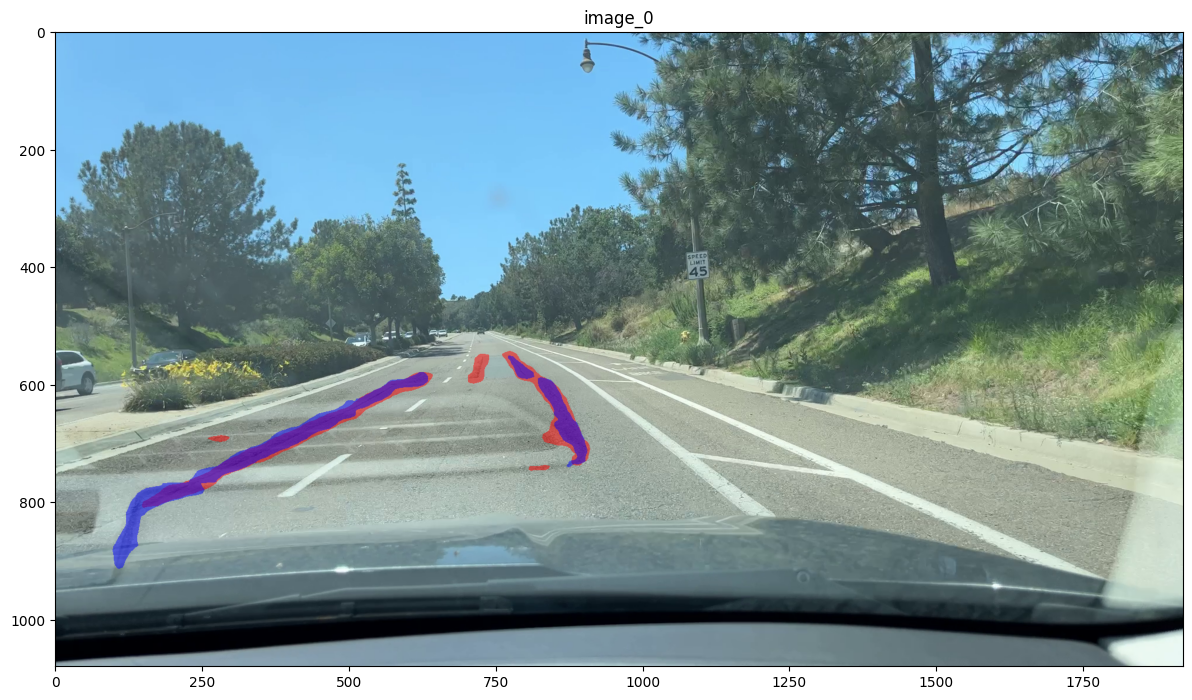

In [69]:
plot(overlay_sample(open_sample(samples, 30)),
     max_col_width=1,
     max_row_height=1)
